## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/eiiijiiiy/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')


Running in Colab.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 840.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12

### Define utils

In [21]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    latent, loss, y, mask = model(x.float(), mask_ratio=0.25)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

    return latent

### Load a pre-trained MAE model

In [22]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth
import models_mae
chkpt_dir = 'mae_visualize_vit_large.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')


File ‘mae_visualize_vit_large.pth’ already there; not retrieving.



<ipython-input-21-225e4ecc1e1b>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chkpt_dir, map_location='cpu')


<All keys matched successfully>
Model loaded.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load an image

In [4]:
# load an image
#img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
#img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img_path = "/content/data/block1/proj_cedd.png"
#img = Image.open(requests.get(img_url, stream=True).raw)
img = Image.open(img_path)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

FileNotFoundError: [Errno 2] No such file or directory: '/content/data/block1/proj_cedd.png'

### Run MAE on the image

In [18]:
block_dir = "/content/mae/geo/hk/blocks/"
block_imgs = os.listdir(block_dir)
sorted(block_imgs)

['11NE25B.png',
 '11NW14A.png',
 '11NW20C.png',
 '11NW25C.png',
 '11SE8A.png',
 '11SW8C.png',
 '11SW9D.png']

MAE with pixel reconstruction:


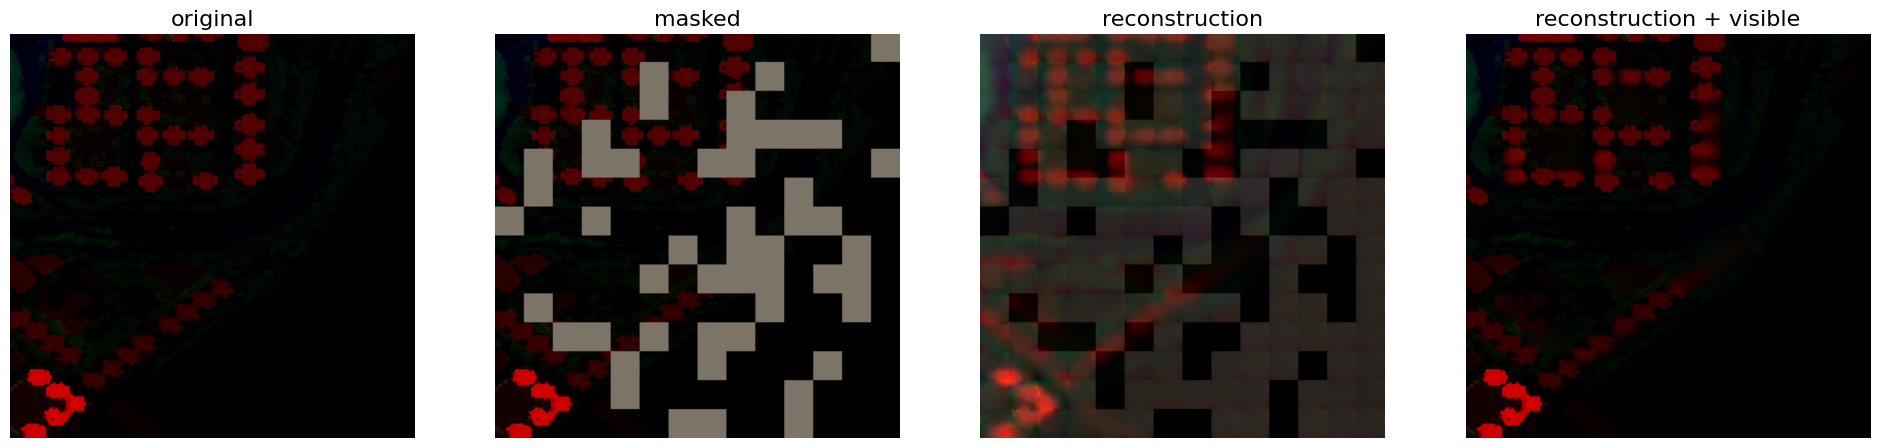

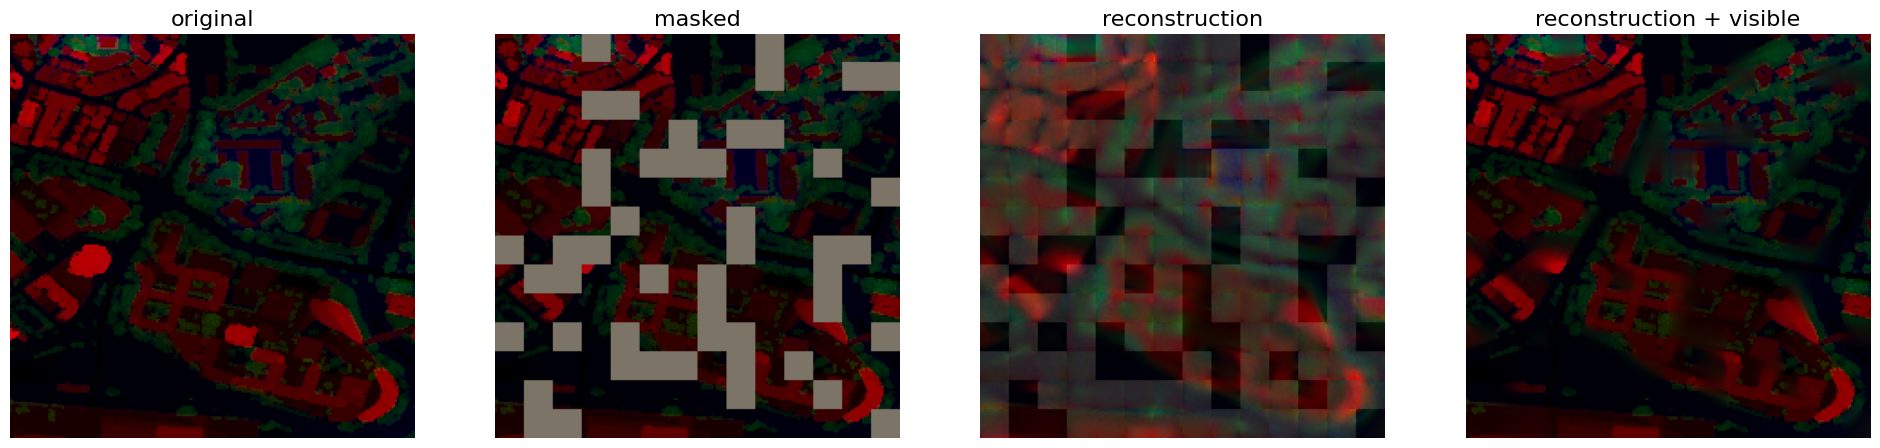

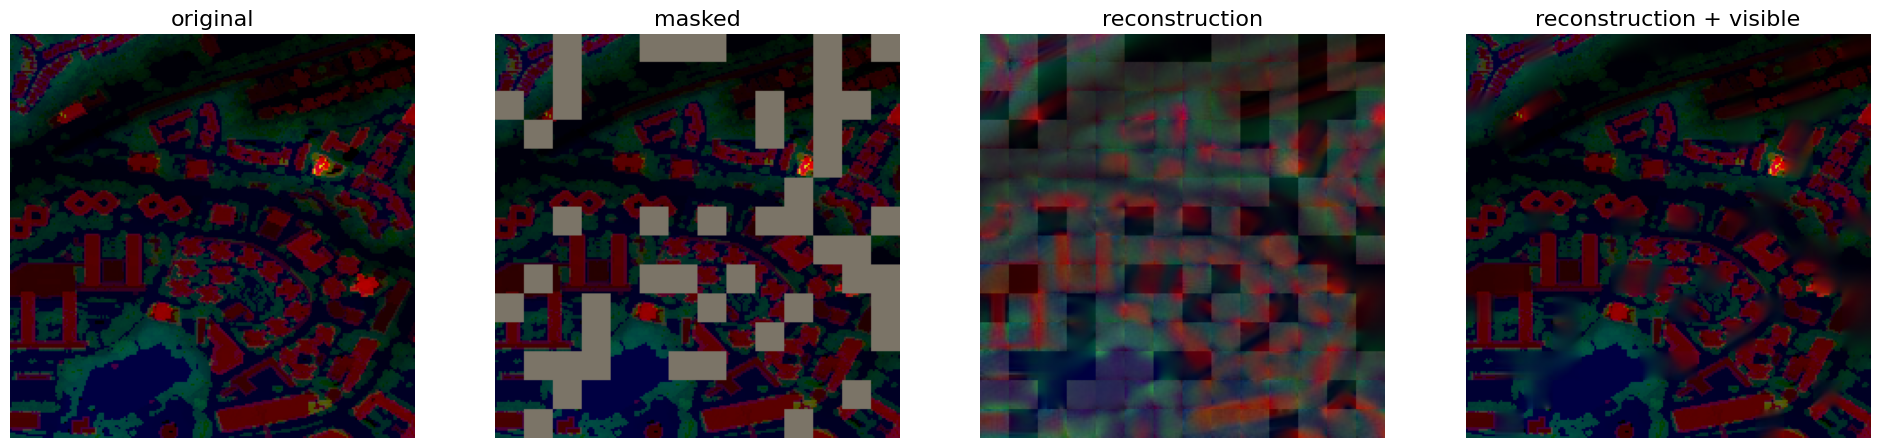

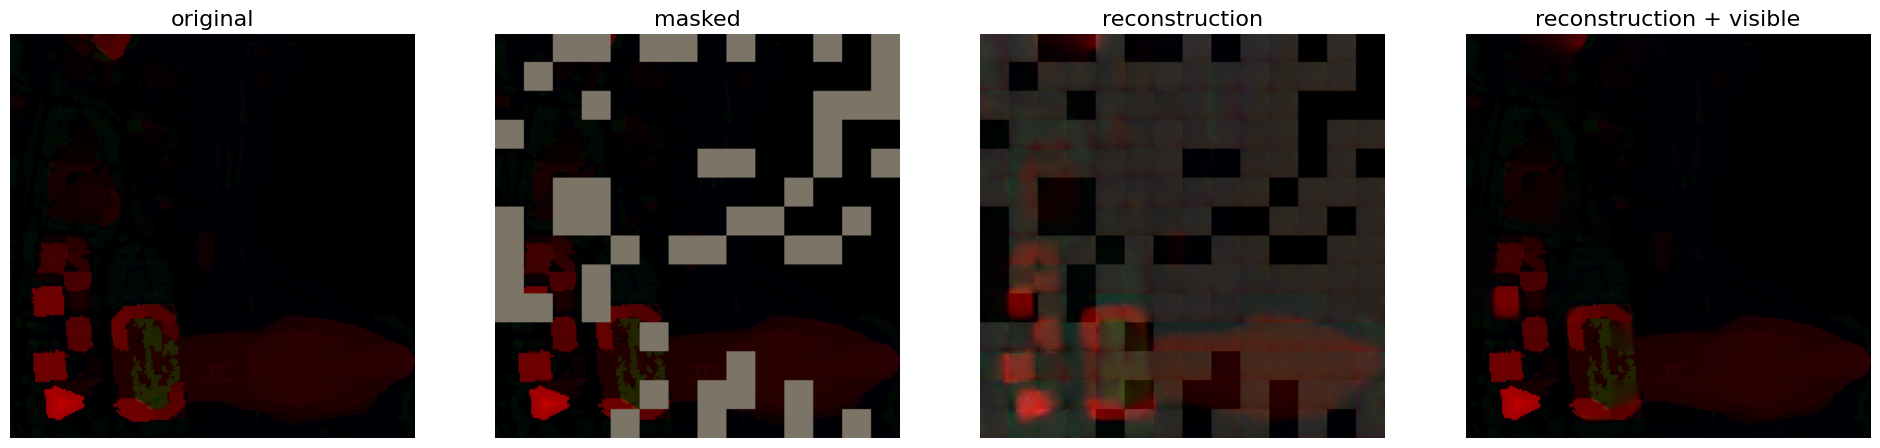

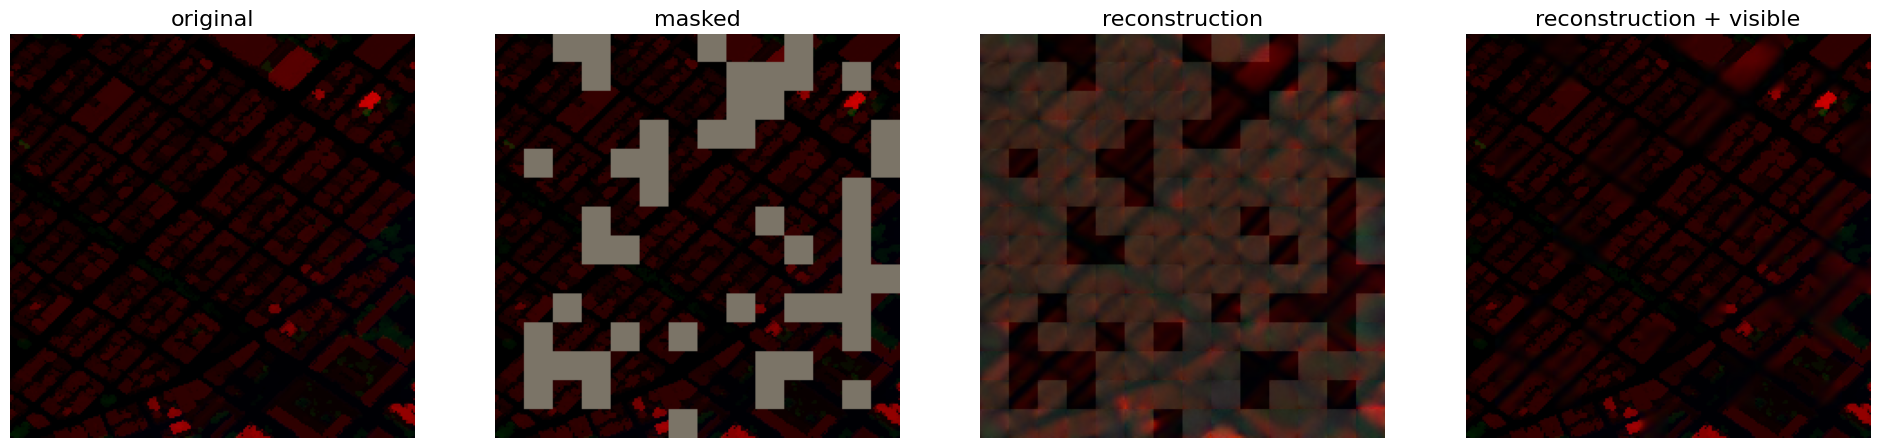

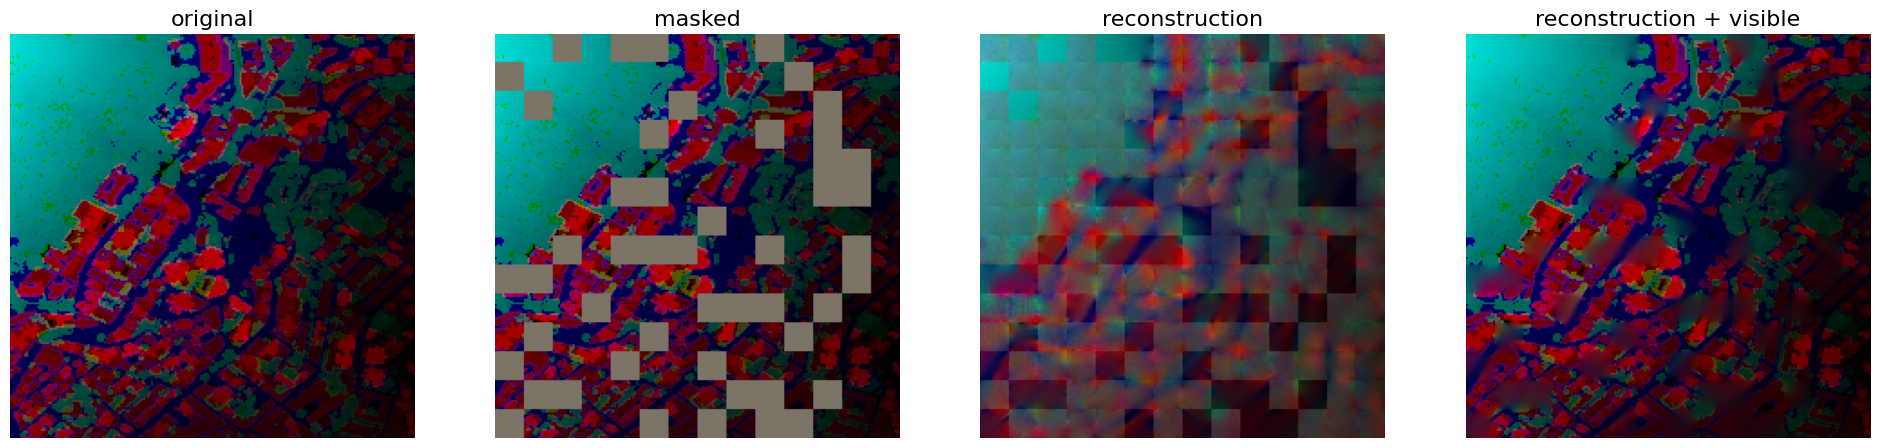

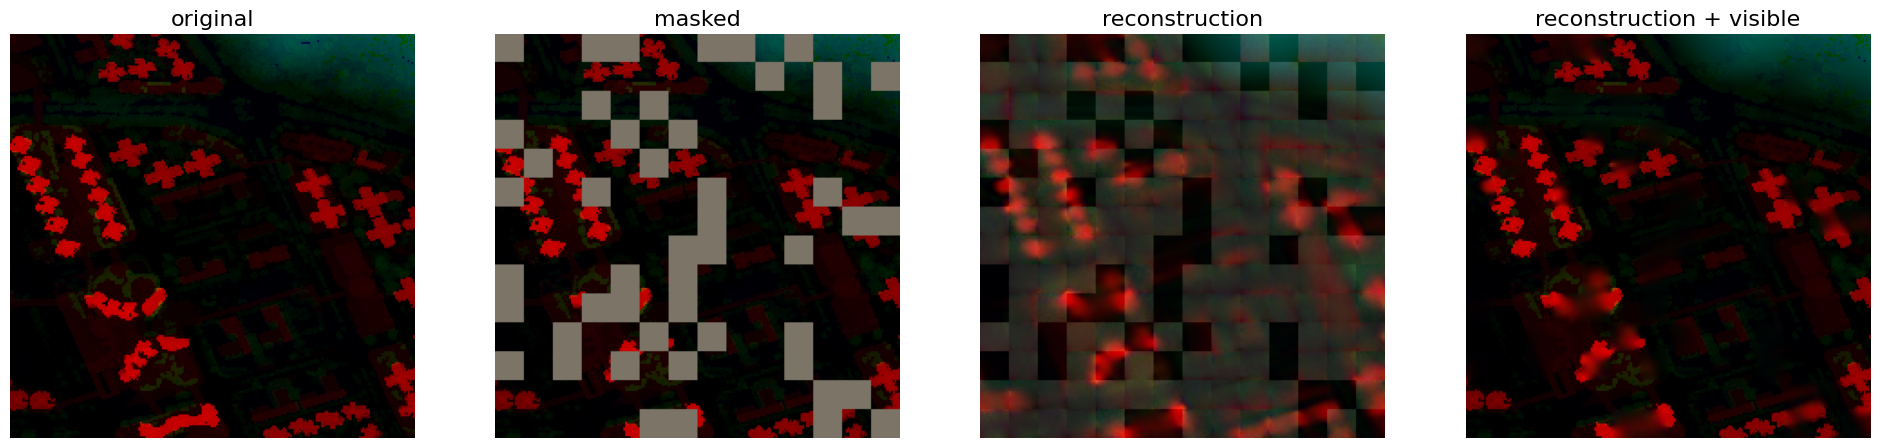

In [24]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
num_imgs = len(block_imgs)
all_latents = np.zeros((num_imgs, 148, 1024))
for i in range(num_imgs):
  bi = block_imgs[i]
  img_path = block_dir + bi
  img = Image.open(img_path)
  img = img.resize((224, 224))
  img = np.array(img) / 255.
  assert img.shape == (224, 224, 3)

  # normalize by ImageNet mean and std
  img = img - imagenet_mean
  img = img / imagenet_std
  latent = run_one_image(img, model_mae)
  all_latents[i, :, :] = latent.detach().numpy()

In [29]:
flattern_vectors = np.reshape(all_latents, (num_imgs, -1))
flattern_vectors.shape

(7, 151552)

### Visualize the latent vectors of the city blocks on 2D space using TSNE






1.   Prepare the environment for clustering and visualization


In [54]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from   sklearn.decomposition import PCA
from   sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, MDS, SpectralEmbedding
from   sklearn.preprocessing import StandardScaler

np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
plt_style = 'seaborn-talk'

# Experimental: HDBScan is a state-of-the-art clustering algorithm
hdbscan_available = True
try:
    import hdbscan
except ImportError:
    hdbscan_available = False

In [44]:
y = np.arange(0, 6)
def do_plot(X_fit, labels, title=None):
    dimension = X_fit.shape[1]
    label_types = sorted(list(set(labels)))
    num_labels = len(label_types)
    colors = cm.Accent(np.linspace(0, 1, num_labels))
    fig = plt.figure()
    if dimension == 2:
        ax = fig.add_subplot(111)
        for lab, col in zip(label_types, colors):
            ax.scatter(X_fit[labels==lab, 0],
                        X_fit[labels==lab, 1],
                        c=col)
    elif dimension == 3:
        ax = fig.add_subplot(111, projection='3d')
        for lab, col in zip(label_types, colors):
            ax.scatter(X_fit[labels==lab, 0],
                        X_fit[labels==lab, 1],
                        X_fit[labels==lab, 2],
                        c=col)
    else:
        raise Exception('Unknown dimension: %d' % dimension)
    plt.title(title)
    plt.show()

clustering and visualization

[[ -78.6729   45.489 ]
 [ -11.534   -32.1143]
 [  18.826  -133.047 ]
 [ -94.0258   58.3246]
 [ -58.5539   14.6579]
 [ 237.6752   50.5021]
 [ -13.7146   -3.8124]]


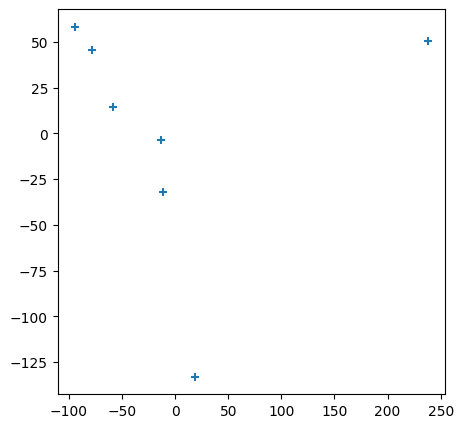

In [65]:
%matplotlib inline
pca = PCA(n_components=2).fit_transform(flattern_vectors)
plt.rcParams['figure.figsize'] = [5, 5]
plt.scatter(pca[:, 0], pca[:, 1], marker="+")
print(pca)
plt.show()

[[ 42.1342 -11.8771]
 [ -2.8979 -51.4979]
 [-29.2935  46.7051]
 [ 44.8332  24.9181]
 [ 11.709   -3.8121]
 [-62.1916  70.5105]
 [-33.9026 -14.7523]]


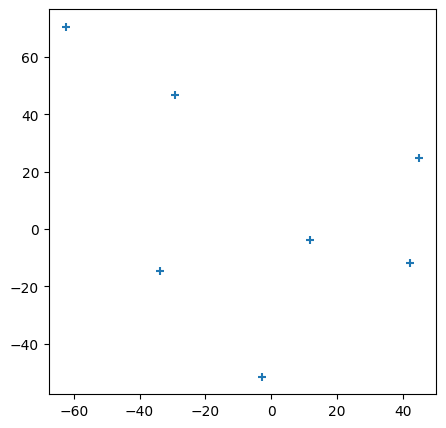

In [70]:
%matplotlib inline
tsne = TSNE(n_components=2, perplexity=2).fit_transform(flattern_vectors)
plt.rcParams['figure.figsize'] = [5, 5]
plt.scatter(tsne[:, 0], tsne[:, 1], marker="o", size=10)
print(tsne)
plt.show()

### Run MAE on the image